In [1]:
from ortools.sat.python import cp_model
import numpy as np
import matplotlib.pyplot as plt
import itertools

Status = OPTIMAL


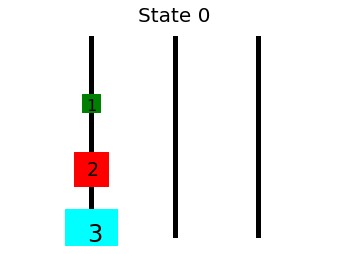

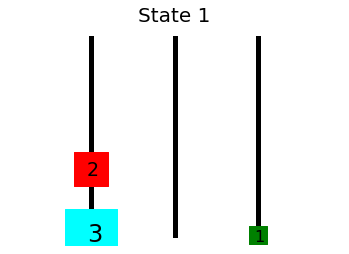

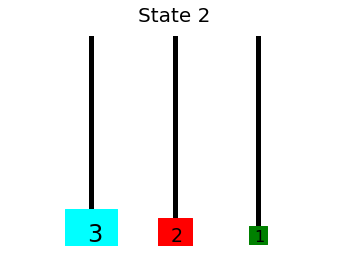

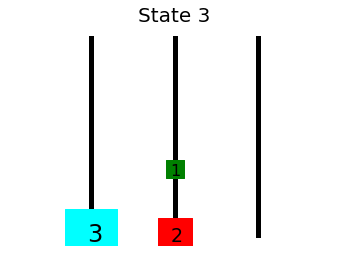

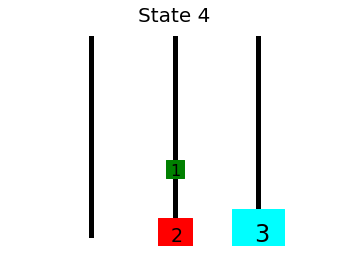

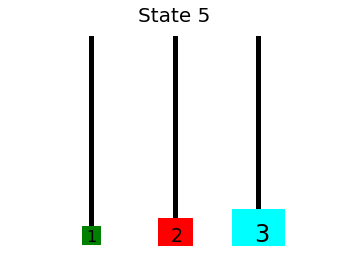

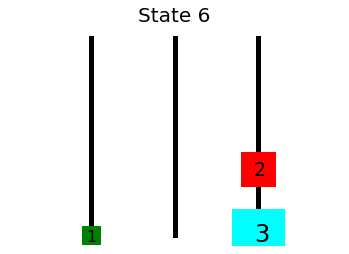

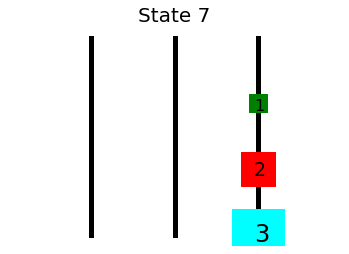

In [7]:
def Tower3(n):
    
    # Creates the model and set solver
    model = cp_model.CpModel()
    solver = cp_model.CpSolver()

    # Number of moves
    S = range(2**n)

    x = {(i,j,s): model.NewIntVar(0, n, f'x_{i}_{j}_{s}') for i in range(3) for j in range(n) for s in S}
    term = {(s): model.NewBoolVar(f'term_{s}') for s in S}
    choice1 = {(i,j,s): model.NewBoolVar(f'choice1_{i}_{j}_{s}') for i in range(3) for j in range(n) for s in S}
    choice2 = {(i,j,s): model.NewBoolVar(f'choice2_{i}_{j}_{s}') for i in range(3) for j in range(n) for s in S}
    
    # Creating initial Tower of Hanoi
    count = n
    for i in range(3):
        for j in range(n):
            if i == 0:
                model.Add(x[i,j,0] == count)
                count-=1
            else:
                model.Add(x[i,j,0] == 0)

    # Must terminate at some point
    model.AddExactlyOne([term[s] for s in S])

    for s in S:
        # If terminated, then the first two towers are all 0, otherwise not
        model.Add(sum(x[i,j,s] for i in range(2) for j in range(n)) == 0).OnlyEnforceIf(term[s])
        model.Add(sum(x[i,j,s] for i in range(2) for j in range(n)) != 0).OnlyEnforceIf(term[s].Not())
        if s > 0:
            # if s != S:
            #     model.Add(term[s-1] <= term[s])
            for a,b in list(itertools.permutations(range(3),2)):
                for j,k in list(itertools.product(range(n),range(n))):
                    # If choice1 is pillar a, index j, then that value in the last stage
                    # must be greater than or equal to 1
                    model.Add(x[a,j,s-1] >= 1).OnlyEnforceIf(choice1[a,j,s])

                    # If choice1 is pillar a, index j, then that value must now be 0
                    model.Add(x[a,j,s] == 0).OnlyEnforceIf(choice1[a,j,s])

                    # If choice2 is pillar b, index j, then that value must have been 0
                    # or open slot in the last stage
                    model.Add(x[b,k,s-1] == 0).OnlyEnforceIf(choice2[b,k,s])

                    # The previous stages value of choice1 is now the current stage's value
                    # of choice2, indicating a move has been made
                    model.Add(x[a,j,s-1] == x[b,k,s]).OnlyEnforceIf(choice1[a,j,s],choice2[b,k,s])
            
            for i in range(3):
                # At each stage a choice can only be made at most once per pillar
                model.AddAtMostOne([choice1[i,j,s] for j in range(n)])
                model.AddAtMostOne([choice2[i,j,s] for j in range(n)])
                # Choice 1 and choice 2 can't be the same pillar
                model.Add(sum(choice1[i,j,s] + choice2[i,j,s] for j in range(n)) <= 1)
                # If a choice is made for choice 1 or 2 then a choice is made for the other
                model.Add(sum(choice1[i,j,s] for i in range(3) for j in range(n)) == sum(choice2[i,j,s]for i in range(3) for j in range(n)))

                for j in range(n):
                    # Value of non-moved items do not change
                    model.Add(x[i,j,s-1] == x[i,j,s]).OnlyEnforceIf([choice1[i,j,s].Not(),choice2[i,j,s].Not()])
                    if j < n-1:
                        # No value on the pillar is greater than the value beneath (to the left of) it
                        model.Add(x[i,j,s] >= x[i,j+1,s])
            
            #model.Add(sum(choice1[i,j,s] + choice2[i,j,s] for i in range(3) for j in range(n)) == 2).OnlyEnforceIf(term[s].Not())

    status = solver.Solve(model)
    print(f"Status = {solver.StatusName(status)}")

    # Storing Solutions
    global sol, final, option1, option2

    sol = [solver.value(x[i,j,s]) for s in S for i in range(3) for j in range(n)]
    sol = np.reshape(sol,(len(S),3,n))

    option1 = [(i,j,s) for s in S for i in range(3) for j in range(n) if solver.value(choice1[i,j,s]) == 1]
    option2 = [(i,j,s) for s in S for i in range(3) for j in range(n) if solver.value(choice2[i,j,s]) == 1]

    final = [solver.value(term[s]) for s in S]

    # Plotting solution
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange',]
    count = 0
    for s in range(len(sol)):
        for i in range(3):
            plt.plot((i,i),(0,3), color = 'k', linewidth = 5, zorder = 0)
            for j in range(n):
                if sol[s,i,j] != 0:
                    plt.scatter(i,j, marker= 's', s = 300*sol[s,i,j]**2, c = colors[sol[s,i,j]])
                    plt.text(i-.05,j-.1,sol[s,i,j], fontsize = 15+sol[s,i,j]**2)
        plt.title(f'State {count}', fontsize = 20)
        plt.axis('off')
        plt.xlim(-1,3)
        plt.show()
        count+=1

Tower3(3)